In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, create_mog
from distributions import log_prob_mix_laplace as log_p
from util import acf, ess, estimate_log_z
from math import log, pi, sqrt, exp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
import numpy as np
from scipy.integrate import quad
from samplers.mcmc import HMC
from pathlib import Path
%matplotlib inline

sd = 2479108
torch.manual_seed(sd)
np.random.seed(sd)

## Load HMC results

In [2]:
results_path= '/home/rlange/parametric-sampling/notebooks/results/'
r=!ls $results_path
hmc_results = []
lambdas = []
for file in r:
    f = file.split('_')
    if 'ext10000.dat' in f:
        dist, mvn, lambda_ = f[1:4]
        if mvn=='MVNIso' and dist=='cigar':
            lambdas.append(lambda_)
            hmc_results.append(torch.load(results_path+file))

In [3]:
results_path= '/home/rlange/parametric-sampling/notebooks/old-results/'
r=!ls $results_path
old_hmc_results = []
old_lambdas = []
for file in r:
    _, dist, mvn, lambda_, _ = file.split('_')
    if mvn=='MVNIso' and dist=='cigar':
        old_lambdas.append(lambda_)
        old_hmc_results.append(torch.load(results_path+file))

In [4]:
# combine old results with recent
for i, l in enumerate(old_lambdas):
    if old_hmc_results[i]['accept']>0 and float(l)<50:
        hmc_results.append(old_hmc_results[i])
        lambdas.append(l)

In [5]:
# sort
s = np.argsort([float(l) for l in lambdas])
lamdbas_s = np.array([float(l) for l in lambdas])[s]
hmc_results_s = [hmc_results[s_] for s_ in s]

In [6]:
# for convenience later
hmc_results_cat=[]
lamdbas_cat=[]
for i, r in enumerate(hmc_results_s):

    lamdbas_cat.append(lamdbas_s[i])
    hmc_results_cat.append(hmc_results_s[i]['samples'])



## 2d examples

In [7]:
### Or choose cigar!!
from distributions import log_prob_cigar as log_p

x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

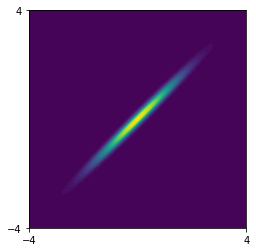

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.set_aspect('equal')
plt.contourf(xx, yy, p_grid, origin='lower', vmin=0., levels=50)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
ax.set_xticks([-4,4])
ax.set_yticks([-4,4])

### Define a 2d polynomial

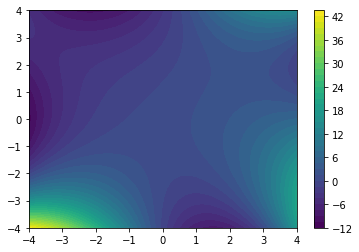

In [9]:
n=5
random_coeffs = torch.randn(n,n)
f = torch.Tensor([[np.math.factorial(n) for n in range(n)]])
nicer_coeffs = random_coeffs/(f+f.T)

def random_poly(xy):
    """Basically np.polynomial.polynomial.polyval2d in pytorch.
    xy can be a (2,n) tensor"""
    if xy.size(0) == 2:
        x, y = xy[0], xy[1]
    else:
        x, y = xy[:, 0], xy[:, 1]
        
    terms = sum([[nicer_coeffs[i,j] * x**i * y**j if i+j<n else 0*x
                                                   for i in range(nicer_coeffs.size(0))]
                                                   for j in range(nicer_coeffs.size(1))], [])
    return torch.stack(terms, dim=0).sum(0) 
        
poly_grid = random_poly(torch.stack((xx,yy)))
plt.contourf(xx, yy, poly_grid, origin='lower', levels=50)
plt.colorbar()

## Get ground truth

In [10]:
from scipy.integrate import dblquad

In [11]:
def integrand(x,y):
    xy = torch.Tensor([x, y])
    return log_p(torch.Tensor(xy)).exp()
norm = dblquad(integrand, -15,15, lambda x: -15, lambda x: 15)[0]
norm

/home/abenjamin/.conda/envs/sampling/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/abenjamin/.conda/envs/sampling/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.8863544527227167

In [12]:
def integrand(x,y):
    xy = torch.Tensor([x, y])
    return random_poly(xy) * log_p(torch.Tensor(xy)).exp()/norm
random_poly_expectation = dblquad(integrand, -15, 15, lambda x: -15, lambda x: 15)
random_poly_expectation

(1.2848415336013332, 1.5853660588016128e-05)

### Compute expectation under variational sol'n

Text(0, 0.5, 'KL(q||p) + log Z')

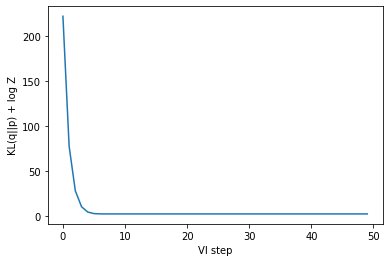

In [13]:
q_vi = MVNIso.new_random(d=2)
q_vi.theta.requires_grad_(True)

def _kl_q_p_helper():
    kl = -q_vi.entropy() - q_vi.quadrature_ev(log_p, 5)
    grad_kl = torch.autograd.grad(kl, q_vi.theta, create_graph=True)[0]
    hess = torch.zeros(q_vi.n_params, q_vi.n_params)
    for i in range(q_vi.n_params):
        hess[i, :] = torch.autograd.grad(grad_kl[i], q_vi.theta, retain_graph=True)[0]
    return kl.detach(), grad_kl.detach(), hess

kl_vals = torch.zeros(50)
for i in range(50):
    kl_vals[i], grad, hess = _kl_q_p_helper()
    with torch.no_grad():
        # Newton's method step
        q_vi.theta.copy_(q_vi.theta - torch.linalg.solve(hess, grad))
q_vi.theta.requires_grad_(False)

plt.figure()
plt.plot(kl_vals)
plt.xlabel('VI step')
plt.ylabel('KL(q||p) + log Z')

tensor(0.7630)


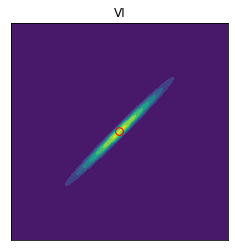

In [14]:
q_vi_expectation = q_vi.quadrature_ev(random_poly, 10)

plt.contourf(xx, yy, p_grid, origin='lower', vmin=0.)
plt.title('VI')
plt.xticks([]); 
plt.yticks([])
plt.axis('image')
plt.plot(*q_vi.ellipse(nsigma=1.), color='r', linewidth=1)
print(q_vi_expectation)

## Plot out the mixtures

10000


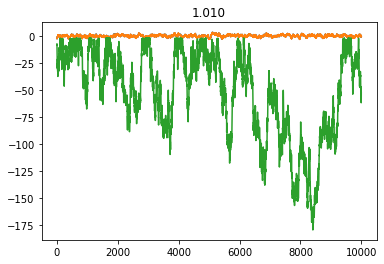

10000


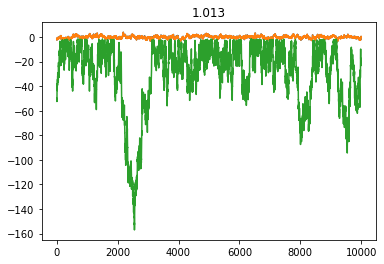

10000


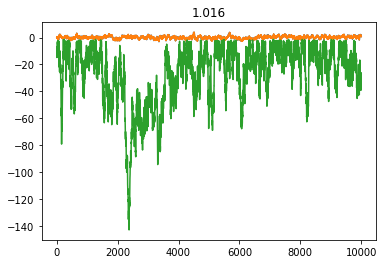

10000


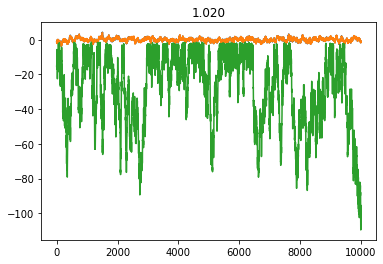

10000


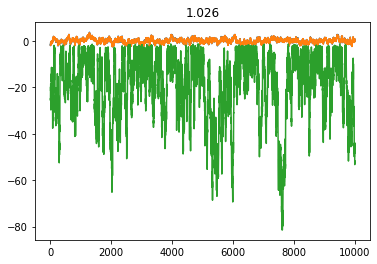

10000


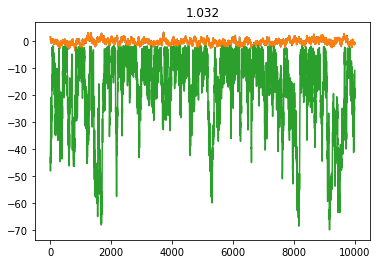

10000


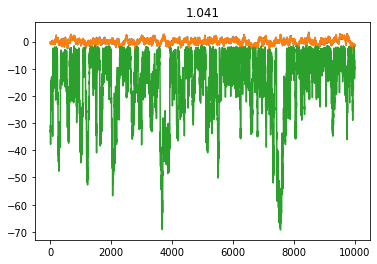

10000


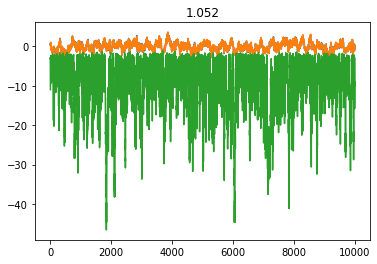

10000


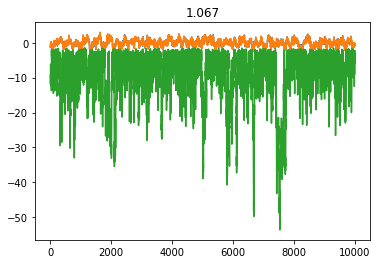

10000


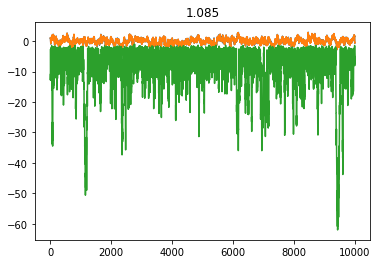

10000


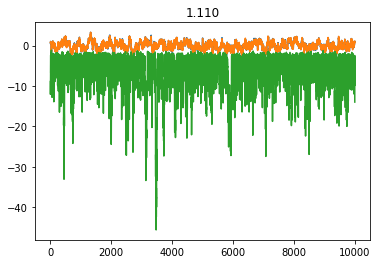

10000


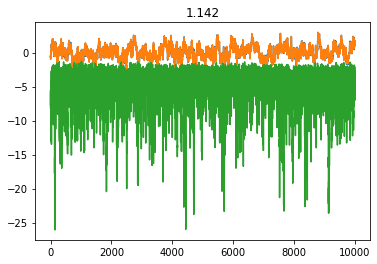

10000


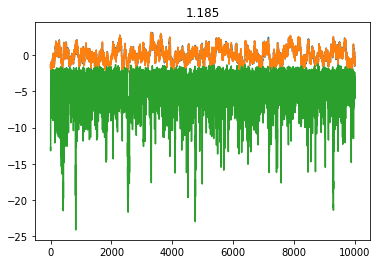

10000


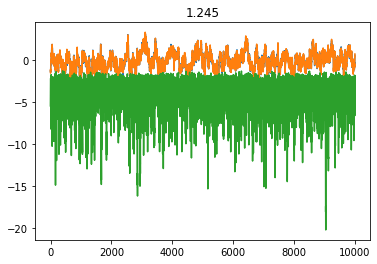

10000


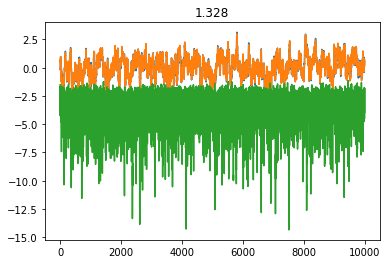

10000


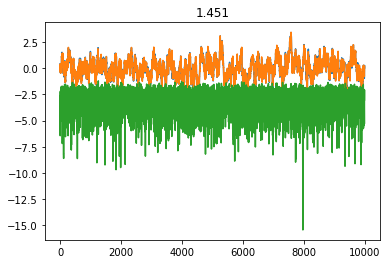

10000


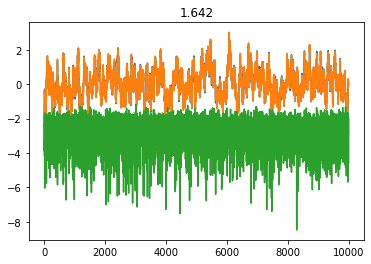

10000


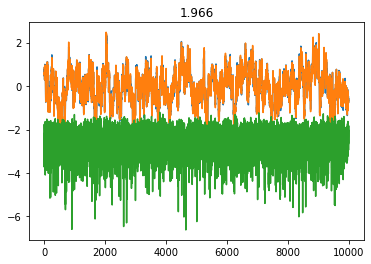

10000


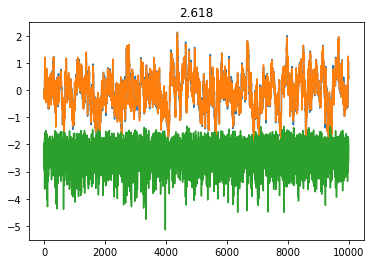

10000


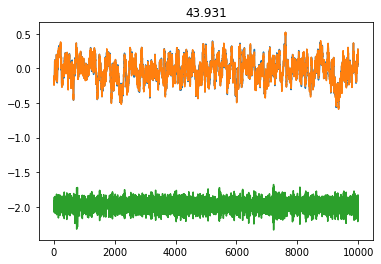

10000


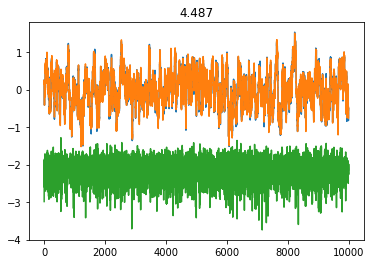

10000


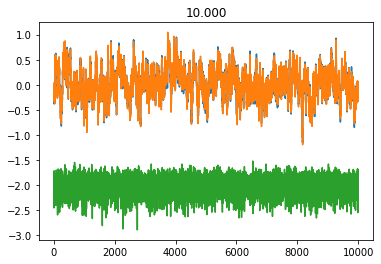

10000


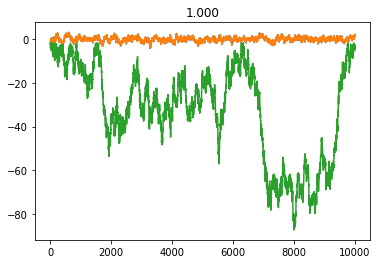

10000


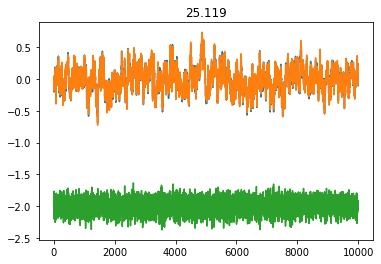

10000


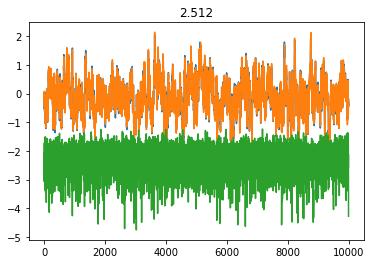

In [15]:
for i, r in enumerate(hmc_results):
    plt.plot(r['samples'])
    print(len(r['samples']))
    plt.title(lambdas[i])
    plt.show()

In [16]:
[h['accept'] for h in hmc_results]

[tensor(0.9345),
 tensor(0.9180),
 tensor(0.9155),
 tensor(0.8948),
 tensor(0.9204),
 tensor(0.8933),
 tensor(0.8827),
 tensor(0.8847),
 tensor(0.8778),
 tensor(0.8515),
 tensor(0.8581),
 tensor(0.8564),
 tensor(0.8698),
 tensor(0.8594),
 tensor(0.8604),
 tensor(0.8507),
 tensor(0.8449),
 tensor(0.8475),
 tensor(0.8439),
 tensor(0.8911),
 tensor(0.8797),
 tensor(0.8289),
 tensor(0.9245),
 tensor(0.8590),
 tensor(0.8553)]

1.010 10000


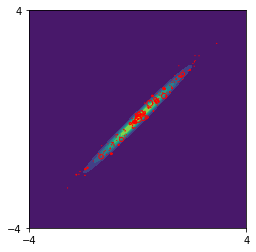

1.013 10000


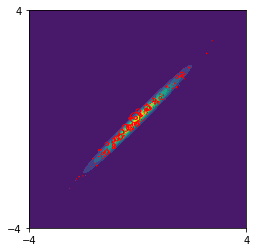

1.016 10000


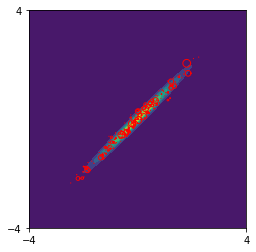

1.020 10000


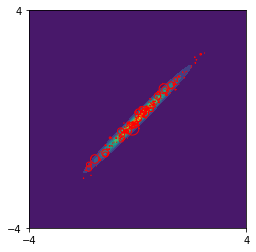

1.026 10000


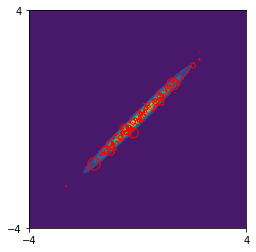

1.032 10000


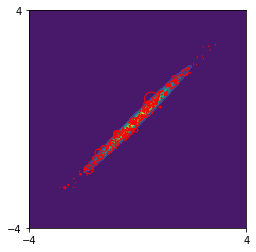

1.041 10000


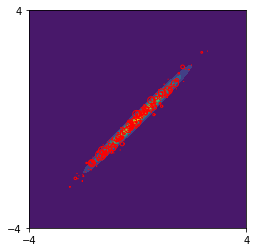

1.052 10000


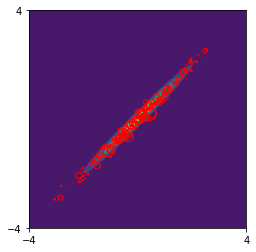

1.067 10000


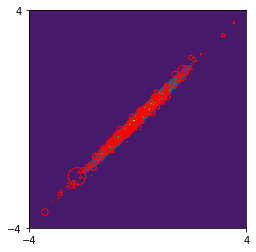

1.085 10000


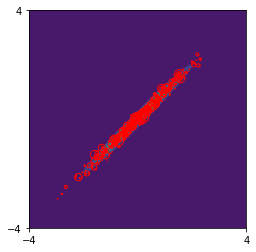

1.110 10000


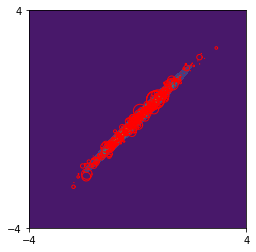

1.142 10000


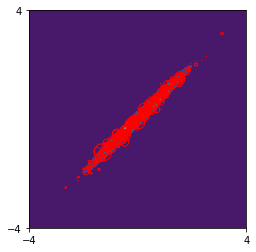

1.185 10000


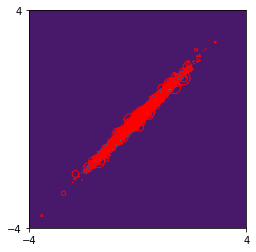

1.245 10000


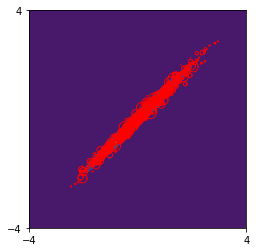

1.328 10000


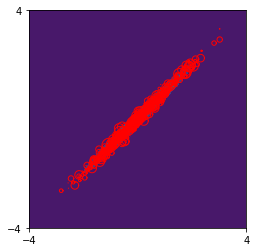

1.451 10000


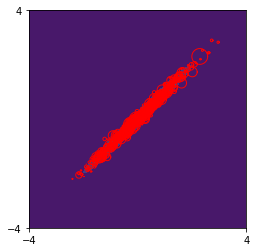

1.642 10000


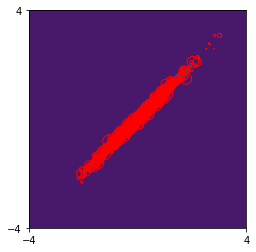

1.966 10000


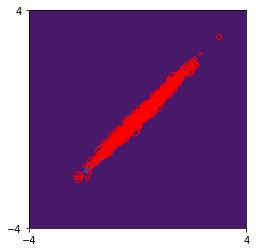

2.618 10000


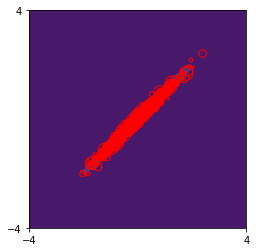

43.931 10000


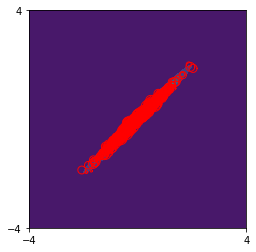

4.487 10000


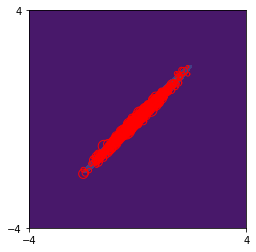

10.000 10000


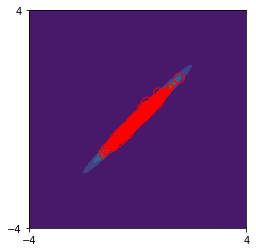

1.000 10000


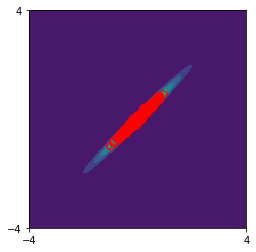

25.119 10000


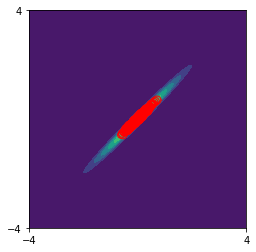

2.512 10000


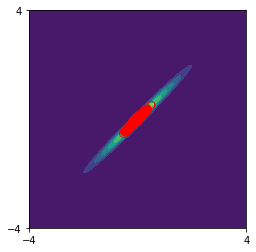

In [17]:
q = MVNIso.new_random(d=2)
for i, r in enumerate(hmc_results_cat):
#     p_grid = torch.stack([q.set_theta(th).to_torch_mvn().log_prob(xy.T).view(201,201).exp()
#                           for th in r['samples']]).mean(0)
#     plt.contourf(xx, yy, p_grid, origin='lower', vmin=0., )
    plt.contourf(xx, yy, p_grid, origin='lower', vmin=0.)
    print(lambdas[i], len(r))
    for th in r[::10]:
        
        plt.plot(*q.set_theta(th).ellipse(nsigma=1.), color='r', linewidth=1)
    plt.axis('image')
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xticks([-4,4])
    ax.set_yticks([-4,4])
    plt.savefig(f"cigar_{lamdbas_cat[i]}.png",dpi=100)
    plt.show()


## Get bias and variance under samples

### Calculate 'asymptotic' bias by computing expected value random polynomial for every value of the chain

In [18]:
q = MVNIso(d=2)
full_chain_expectations = torch.zeros(len(lamdbas_cat))
for i, r in enumerate(hmc_results_cat):
    component_evs = [q.set_theta(th).quadrature_ev(random_poly, n=10) for th in r]
    full_chain_expectations[i] = torch.tensor(component_evs).mean()

### Plot EVs

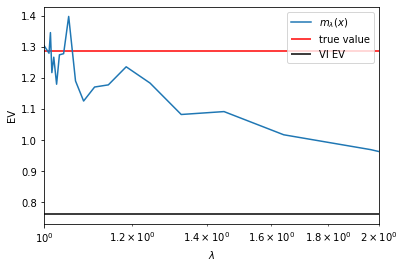

In [19]:
plt.semilogx(lamdbas_cat, full_chain_expectations)
plt.hlines(random_poly_expectation[0], 1,2,color='r')
plt.hlines(q_vi_expectation, 1,2,color='k')
plt.xlabel("$\lambda$");
plt.ylabel("EV")
plt.legend(['$m_\lambda(x)$', 'true value', 'VI EV'])
# plt.ylim(-10,10)
plt.xlim(1,2)
plt.show()

### Calculate variance by subsampling each chain down to 100 samples many times

In [20]:
def get_variance(t=100):
    n_subsample = t
    q = MVNIso(d=2)
    est_variance = torch.zeros(len(lamdbas_cat))
    for i, r in enumerate(hmc_results_cat):
        n_run = len(r)//n_subsample
        subsample_expectations =torch.zeros(n_run)                 
        for j in range(n_run):
            ind = torch.randperm(r.size(0))[:n_subsample]
            subset_samples = r[ind, :]
            component_evs = [q.set_theta(th).quadrature_ev(random_poly, n=10) for th in subset_samples]
            subsample_expectations[j] = torch.tensor(component_evs).mean()
            est_variance[i] =torch.mean((subsample_expectations - full_chain_expectations[i])**2)
    return est_variance
est_variance = get_variance(10)

### Plot bias$^2$ and variance

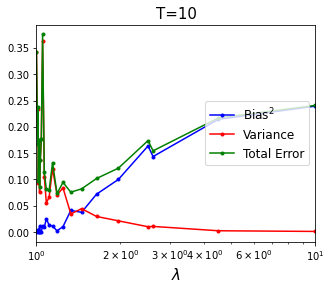

In [21]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
bias2 = (full_chain_expectations - random_poly_expectation[0])**2
mse = bias2 + est_variance

plt.semilogx(lamdbas_cat, bias2, '-b', marker='.')
plt.semilogx(lamdbas_cat, est_variance, '-r', marker='.')
plt.semilogx(lamdbas_cat, mse, '-g', marker='.')
# plt.vlines(n_subsample/(n_subsample-1),*plt.ylim())
plt.xlabel("$\lambda$", fontsize=15);
plt.legend(['Bias$^2$', 'Variance', 'Total Error'],fontsize=12, loc=5)
plt.xlim(1,10)
plt.title("T=10", fontsize=15)
plt.savefig("T=10_bias.pdf")
plt.show()

### Best lambda with T

In [22]:
best_l = []
for t in np.logspace(0,2,10):
    T = int(t)
    est_variance = get_variance(T)
    bias2 = (full_chain_expectations - random_poly_expectation[0])**2
    mse = bias2 + est_variance
    best_l.append(lamdbas_cat[mse[:-2].argmin()])

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
t = np.logspace(0,2,10)
plt.plot(t, t/(t-1), 'r--', label=r'Theory: $\frac{T}{T-1}$')
# ax.set_aspect(50)
plt.plot(np.logspace(0,2,10), best_l, 'k', label='Empirical')
plt.xlabel("T", fontsize=15);
plt.ylabel("Optimal $\lambda$", fontsize=15)
plt.ylim(1,2.7)
plt.legend()
plt.savefig("optimal_lam.pdf")
plt.show()

## Make envelopes w/100 samples

In [ ]:
plt.fill_between(lamdbas_cat, full_chain_expectations-est_variance.sqrt(), 
                             full_chain_expectations+est_variance.sqrt(), alpha=.3)
plt.plot(lamdbas_cat, full_chain_expectations, label = '$m_\lambda(x)$')
ax = plt.gca()
ax.set_xscale('log')
plt.xlim(1,4)
# plt.ylim(-1,10)
plt.hlines(random_poly_expectation[0], 1,41,color='r',label = 'true value', linestyle='--',linewidth=2)
plt.hlines(q_vi_expectation, 1,41,color='k',label='VI EV' , linewidth=2, linestyle='--',)
plt.xlabel("$\lambda$", fontsize=15);
plt.ylabel("Expected value", fontsize=15)
plt.legend(loc=4, fontsize=12)
plt.savefig("cigar_bias_variance.pdf")
plt.show()